In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/corndiseasedetection/corn_dataset"

In [4]:
image_size = 256
batch_size = 16
channel = 3
n_classes = 4

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4000 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Healthy_Leaf', 'Leaf_Blight', 'Leaf_Rust', 'Leaf_Spot']

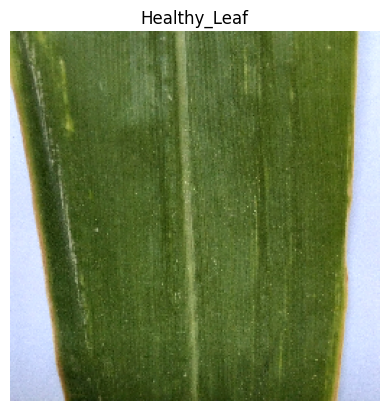

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [8]:
def split_dataset(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset , val_dataset , test_dataset = split_dataset(dataset=dataset)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_dataset)

200

In [12]:
len(test_dataset)

25

In [13]:
len(val_dataset)

25

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [15]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1.0/255)
])

In [17]:
model = models.Sequential([

     resize_and_rescale,


    layers.Conv2D(96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(image_size,image_size,channel)),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding="valid"),


    layers.Conv2D(256,kernel_size=(5,5),strides=1,padding="same",activation="relu"),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding="valid"),


    layers.Conv2D(384,kernel_size=(3,3),strides=1,padding="same",activation="relu"),

    layers.Conv2D(384,kernel_size=(3,3),strides=1,padding="same",activation="relu"),

    layers.Conv2D(256,kernel_size=(3,3),strides=2,padding="same",activation="relu"),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding="valid"),

    layers.Flatten(),

    layers.Dense(2304,activation="relu"),

    layers.Dropout(0.5),

    layers.Dense(4096,activation="relu"),

    layers.Dropout(0.5),


    layers.Dense(4096,activation="relu"),

    layers.Dense(1000,activation="relu"),

    layers.Dense(n_classes ,activation="softmax"),
])

In [18]:
model.build(input_shape=(None,image_size,image_size,channel))

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 384)      

In [20]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [21]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
200/200 [==============================] - 94s 292ms/step - loss: 1.2361 - accuracy: 0.3616 - val_loss: 0.8441 - val_accuracy: 0.6175 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - 30s 148ms/step - loss: 0.7485 - accuracy: 0.6531 - val_loss: 0.5472 - val_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 3/50
200/200 [==============================] - 29s 147ms/step - loss: 0.5583 - accuracy: 0.7344 - val_loss: 0.5426 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 4/50
200/200 [==============================] - 30s 149ms/step - loss: 0.4823 - accuracy: 0.7884 - val_loss: 0.3177 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/50
200/200 [==============================] - 32s 160ms/step - loss: 0.4613 - accuracy: 0.8116 - val_loss: 0.3019 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 6/50
200/200 [==============================] - 30s 149ms/step - loss: 0.4075 - accuracy: 0.8359 - val_loss: 0.2922 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 7/50
200/200 [========

In [22]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

25/25 [==============================] - 34s 19ms/step - loss: 0.1744 - accuracy: 0.9275
Test Accuracy: 0.9275000095367432


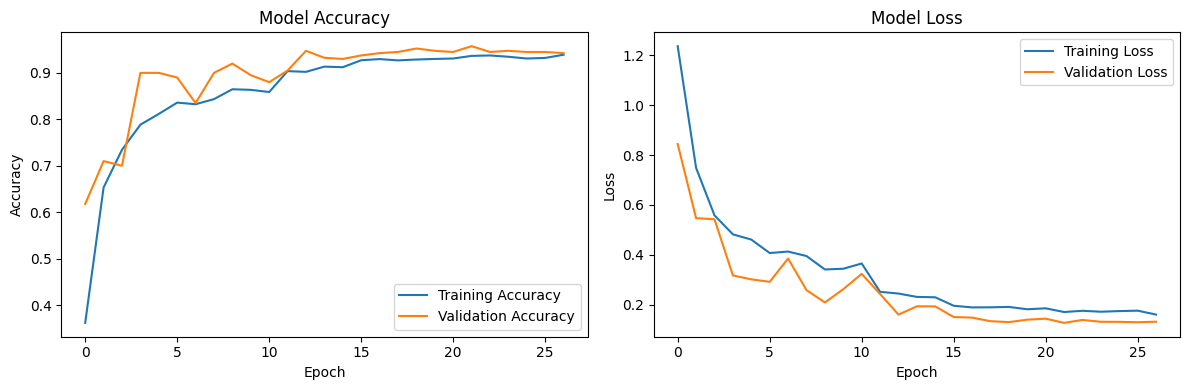

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


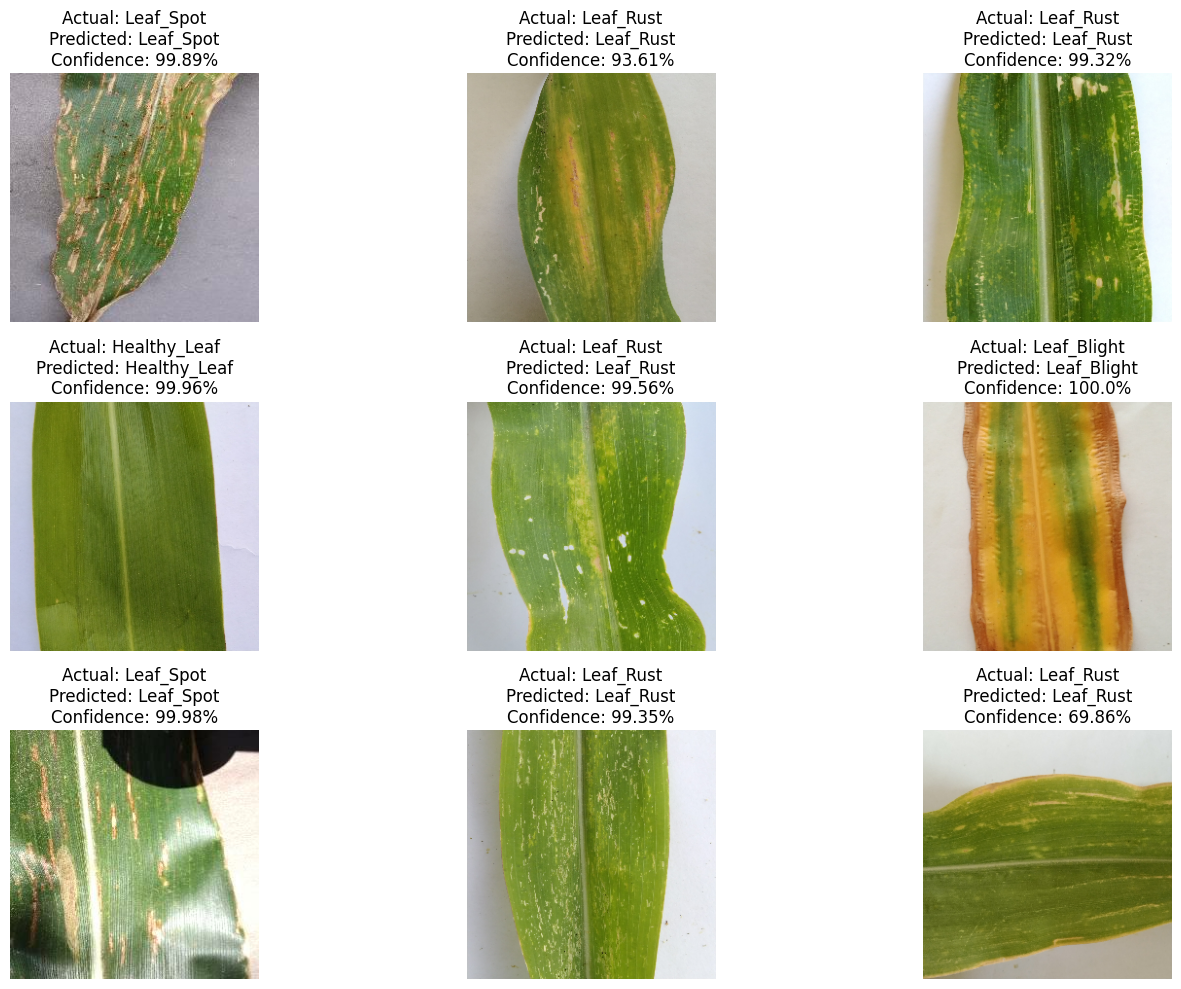

In [25]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 31ms/step


<Figure size 1000x800 with 0 Axes>

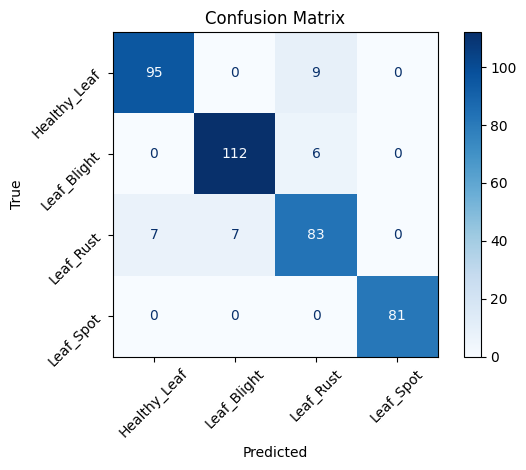

In [26]:
y_true = []
y_pred = []
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

display_labels = [
    'Healthy_Leaf',
    'Leaf_Blight',
    'Leaf_Rust',
    'Leaf_Spot'
]

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("F1 Scores:")
print("Healthy_Leaf:", f1_scores[0])
print("Leaf_Blight:", f1_scores[1])
print("Leaf_Rust:", f1_scores[2])
print("Leaf_Spot:", f1_scores[3])

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)

F1 Scores:
Healthy_Leaf: 0.9223300970873786
Leaf_Blight: 0.9451476793248945
Leaf_Rust: 0.8512820512820514
Leaf_Spot: 1.0
Macro-averaged F1 Score: 0.9296899569235811


In [28]:
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])
recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("Precision:")
print("Healthy_Leaf:", precision[0])
print("Leaf_Blight:", precision[1])
print("Leaf_Rust:", precision[2])
print("Leaf_Spot:", precision[3])

print("\nRecall:")
print("Healthy_Leaf:", recall[0])
print("Leaf_Blight:", recall[1])
print("Leaf_Rust:", recall[2])
print("Leaf_Spot:", recall[3])

Precision:
Healthy_Leaf: 0.9313725490196079
Leaf_Blight: 0.9411764705882353
Leaf_Rust: 0.8469387755102041
Leaf_Spot: 1.0

Recall:
Healthy_Leaf: 0.9134615384615384
Leaf_Blight: 0.9491525423728814
Leaf_Rust: 0.8556701030927835
Leaf_Spot: 1.0


In [29]:
model.save('corndisease_alexnetmodel.h5')

In [30]:
model.save('corndisease_alexnetmodel.keras')